# Custom Retrievers

This notebook will walk through how to get going optimizing your vector retrieval with a custom retriever. This will allow you to test how different queries can be used to get a better overall results.

## 1 - loading a dataset

For the retrieval optimization framework to run it requires a set of raw chunks and a set of queries with labeled chunks. The labeling tool can be used to generate these artifacts from an existing index or they can be created manually. See [README.md](../../README.md) for more information or checkout [process_data.ipynb](./process_data.ipynb).

In the previous example, we loaded one set of chunks that only included data from one pdf document - a mazda 3 owner's manual. For this example we will load an already generated set of chunks for 2 different documents - mazda 3 and volvo c30.

In [1]:
import json

with open("data/combined_chunks.json", "r") as f:
    chunks = json.load(f)

chunks[0]

{'text': "Mazda3_8Y64-EA-08A_Edition1 Page1 Tuesday, November 27 2007 9:0 AM\n\nForm No.8Y64-EA-08A\n\nBlack plate (1,1)\n\nMazda3_8Y64-EA-08A_Edition1 Page2 Tuesday, November 27 2007 9:0 AM\n\nForm No.8Y64-EA-08A\n\nBlack plate (2,1)\n\nMazda3_8Y64-EA-08A_Edition1 Page3 Tuesday, November 27 2007 9:0 AM\n\nBlack plate (3,1)\n\nA Word to Mazda Owners\n\nThank you for choosing a Mazda. We at Mazda design and build vehicles with complete customer satisfaction in mind.\n\nTo help ensure enjoyable and trouble-free operation of your Mazda, read this manual carefully and follow its recommendations.\n\nAn Authorized Mazda Dealer knows your vehicle best. So when maintenance or service is necessary, that's the place to go.\n\nOur nationwide network of Mazda professionals is dedicated to providing you with the best possible service.\n\nWe assure you that all of us at Mazda have an ongoing interest in your motoring pleasure and in your full satisfaction with your Mazda product.\n\nMazda Motor Corp

In [2]:
with open("data/combined_labeled.json", "r") as f:
    labeled = json.load(f)

labeled[0]

{'query': 'At what speed should I shift from 2 to 3 with a manual transmission?',
 'query_metadata': {'make': 'mazda', 'model': '3'},
 'relevant_item_ids': ['mazda_3:86']}

#### Notes on the data

Unlike the basic example we are now loading data from multiple sources and there is an additional attribute called `query_metadata`. This is a named dict within the retrieval optimizer which can be used to load additional fields into the index and/or create more meaningful queries that combine vector search with additional filters etc. 

## 2 - python dependencies & env setup

This project utilizes poetry for dependency management. If you like, in the project root you can run `poetry install` then set the kernel version of this notebook to point to the path of the python interpreter poetry is referencing. This can be accomplish by running `poetry env info --path` after installing and setting as your kernel for the notebook.

Alternatively you can run the following line to import in a notebook native way for convenience.

`!pip install numpy redisvl sentence-transformers redis optuna pandas nest-asyncio`

## Important!

The following code allows for us to run async functions in jupyter and adds the optimize module to path for easy import.

In [1]:
import sys
import os

# Add the parent directory to the Python path to get optimize module
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

import nest_asyncio

# Apply the nest_asyncio patch: let's us run async code in Jupyter
nest_asyncio.apply()

## 3 - defining a study config

Under the hood, this framework is performing bayesian optimization utilizing the optuna library. This process determines the set of decision variables that best optimize the cost function. It accomplishes this by trying different combinations of the decision variables and intelligently traversing the solution space in the direction of best results.

At current the available decision variables are:

- algorithm ("hnsw" or "flat")
  - if hnsw secondary hyper-parameters of ef_runtime, ef_construction, and m can also be optimized.
- vector data type
- ret k
- embedding model

Different configurations of these variables will be attempted in order to **maximize** the following equation: `obj = w0 * f1 + w1 * norm_embedding_latency + w2 * norm_indexing_time` expressed in vector notation this is the dot product of `weights * metrics`. If there are additional metrics you would like to optimize over feel free to open an issue and we can look into adding it!

#### study_config.yaml
```yaml
input_data_type: "json" # currently only json but considering alternatives
raw_data_path: "data/mazda_chunks.json" # path to data files for easy read
labeled_data_path: "data/mazda_labeled.json" # labeled data

# optimization config
n_trials: 20
n_jobs: 1

# metrics to be used in objective function
metrics: ["f1_at_k", "embedding_latency", "total_indexing_time"] 
weights: [1, 1, 1] # weight of each metric respectively 

# optimization decision variables
algorithms: ["flat", "hnsw"] # indexing algorithms variables
vector_data_types: ["float32", "float16"] # vector type of indexed vectors
ret_k: [1, 10] # potential range of value to be sampled during study

# ef_runtime, ef_construction, and m only relevant if HNSW indexing
ef_runtime: [10, 20, 30, 50]
ef_construction: [100, 150, 200, 250, 300]
m: [8, 16, 64]

# embedding models to be used
embedding_models:
  - provider: "hf"
    model: "sentence-transformers/all-MiniLM-L6-v2"
    dim: 384
  - provider: "hf"
    model: "intfloat/e5-large-v2"
    dim: 1024
```

#### Load the study config


In [6]:
from optimize.study import load_config

study_config = load_config("combined_study_config.yaml") # Loads yaml into pydantic model

study_config

StudyConfig(study_id='358c4a71-e799-440c-9432-22515a0d4cfd', redis_url='redis://localhost:6379/0', algorithms=['flat', 'hnsw'], vector_data_types=['float32', 'float16'], raw_data_path='data/combined_chunks.json', input_data_type='json', labeled_data_path='data/combined_labeled.json', embedding_models=[EmbeddingModel(provider='hf', model='sentence-transformers/all-MiniLM-L6-v2', dim=384), EmbeddingModel(provider='hf', model='intfloat/e5-large-v2', dim=1024)], metrics=['f1_at_k', 'embedding_latency', 'total_indexing_time'], weights=[1.0, 1.0, 1.0], n_trials=20, n_jobs=1, ret_k=(1, 10), ef_runtime=[10, 20, 30, 50], ef_construction=[100, 150, 200, 250, 300], m=[8, 16, 64])

# 4 - running a redis instance

For the following code to work we need to have a running instance of redis. 

The easiest way to do this is with docker:

`docker run -d --name redis -p 6379:6379 -p 8001:8001 redis/redis-stack:latest`

#### Note: running redis-stack will expose a GUI (Redis Insight) for interacting with your data on port 8001

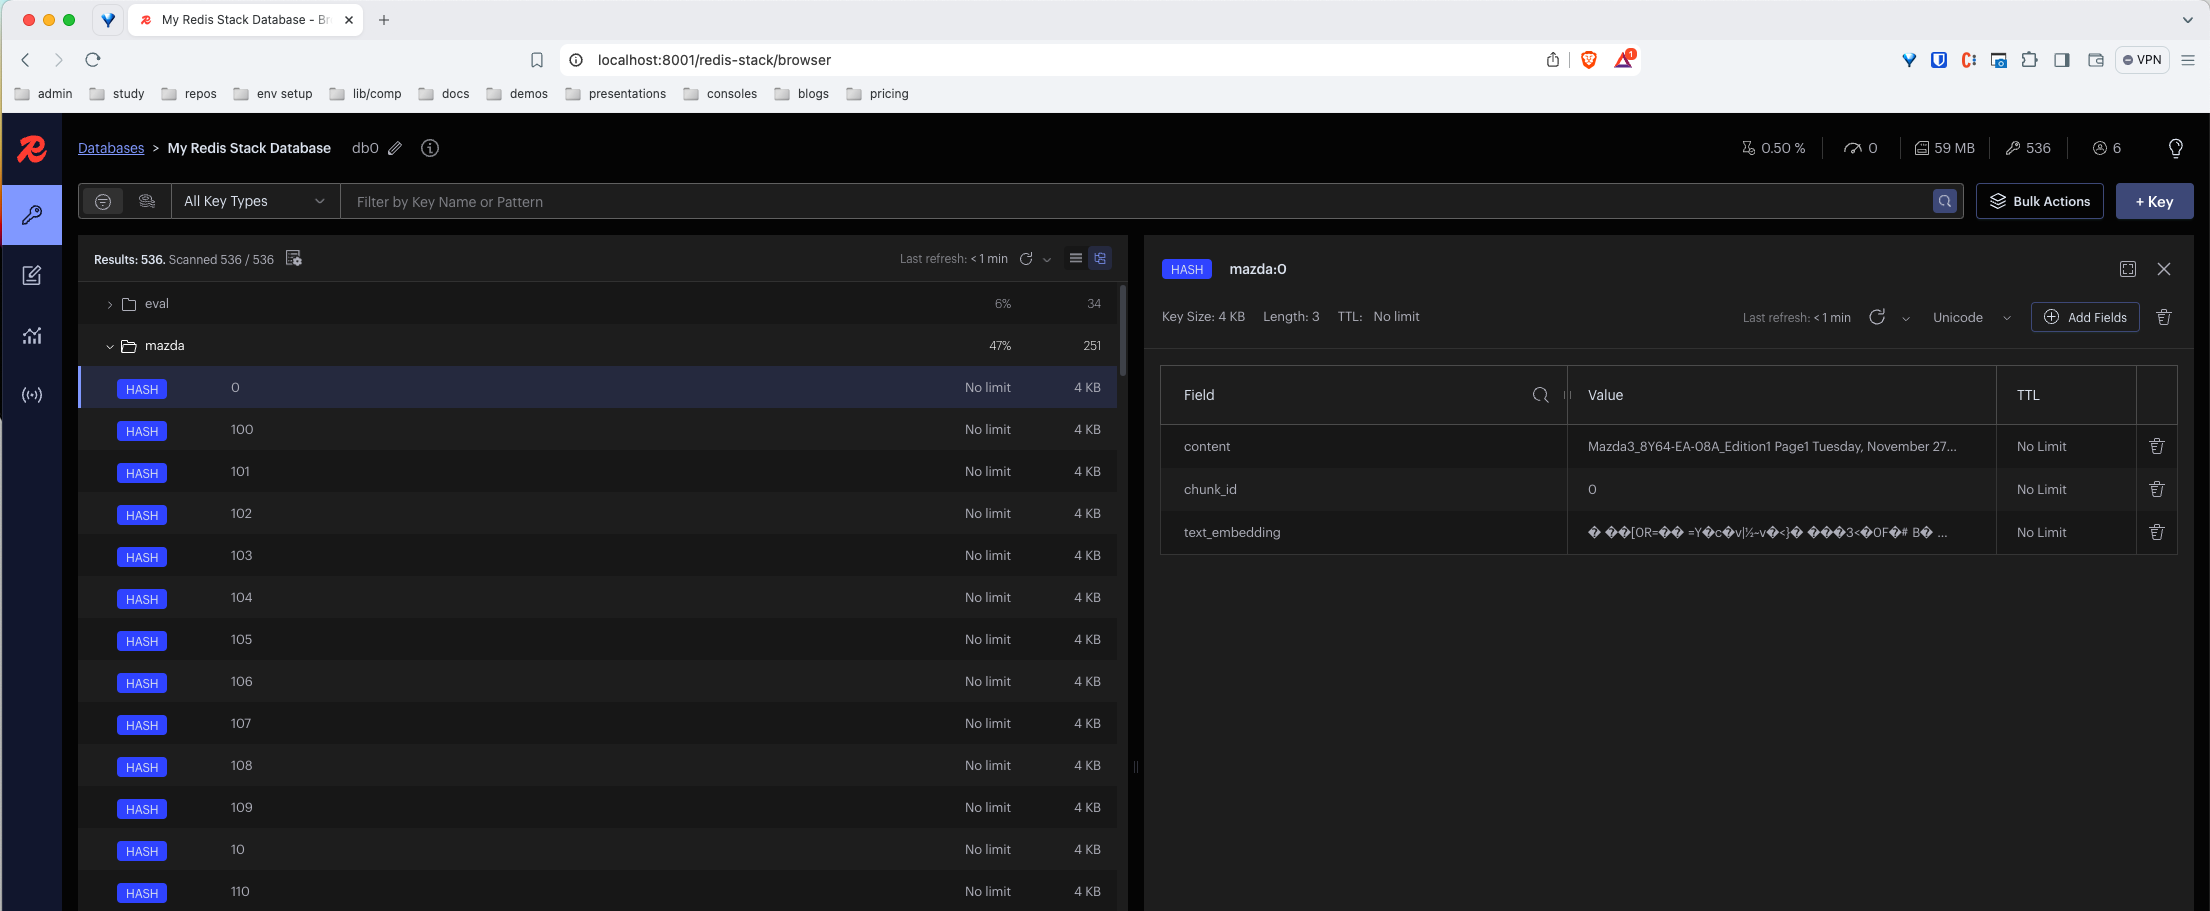

# 5 - Define custom Retriever Class

Since we now have 2 distinct document sets that we are fetching from `mazda` and `volvo` respectfully a default knn query is not going to be as effective. This is where custom retrievers come in. In the following code we extend the `DefaultQueryRetriever` and override the `query_fn` method to utilize the `query_metadata` we have added to our data which will let us augment our vector search on `make` and `model`.

**Note:** for any custom query that can be run against the Redis instance via `index.query()` all that is required is to extend the `DefaultQueryRetriever`. 

In [3]:
from optimize.retrievers import DefaultQueryRetriever
from optimize.models import LabeledItem
from redisvl.query import VectorQuery
from redisvl.utils.vectorize import BaseVectorizer
from redisvl.query.filter import Tag

class MakeModelQueryRetriever(DefaultQueryRetriever):
    def query_fn(
        self, emb_model: BaseVectorizer, labeled_item: LabeledItem, dtype: str, k: int
    ) -> VectorQuery:
        make = labeled_item.query_metadata["make"]
        model = labeled_item.query_metadata["model"]

        make_filter = Tag("make") == make
        model_filter = Tag("model") == model
        make_model_filter = make_filter & model_filter

        vec_query = VectorQuery(
            vector=emb_model.embed(labeled_item.query, as_buffer=True, dtype=dtype),
            vector_field_name="vector",
            return_score=True,
            return_fields=["item_id"],
            num_results=k,
            filter_expression=make_model_filter,
        )

        print(f"{vec_query.query_string()=}")
        return vec_query


#### Important must also specify the additional fields to be added to the schema

The `Eval` class dynamically creates a default index however since we have fields beyond just the basic `text` and `item_id` we need to provide a list of fields to index that matches the fields provided in the `query_metadata`. These fields should be provided in the format:

```json
[
    {
        "name": "field_name",
        "type": "field_type"
    }
]
```

In [4]:
additional_fields = [{"name": "make", "type": "tag"}, {"name": "model", "type": "tag"}]

Once we have defined the custom query retriever all we have to do is pass it to the `Eval` class along with our additional fields:

In [8]:
from optimize.eval import Eval

e = Eval(
    model_provider="hf",
    model_str="intfloat/e5-large-v2",
    embedding_dim=1024,
    raw_data_path="data/combined_chunks.json",
    labeled_data_path="data/combined_labeled.json",
    input_data_type=study_config.input_data_type,
    vector_data_type=study_config.vector_data_types[0],
    algorithm=study_config.algorithms[0],
    ret_k=4,
    find_threshold=False,
    retriever=MakeModelQueryRetriever, # pass in custom retriever
    additional_schema_fields=additional_fields,
)

2024-11-25 11:07:40,735 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-25 11:07:43,975 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:08:12,680 - INFO - Indexing data...
2024-11-25 11:08:13,018 - INFO - Data indexed. self.total_indexing_time=145.51400756835938s


#### Now let's calculate metrics

In [9]:
e.calc_metrics()

2024-11-25 11:08:19,662 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2


2024-11-25 11:08:21,256 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-25 11:08:22,674 - INFO - Calculating retrieval metrics for test_id: 4e8a5e9c-56ec-443b-832c-921804812def
2024-11-25 11:08:22,682 - INFO - Overall f1 at 4 for retrieval: 0.5095238095238095


vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


### Note the overall retrieval 

Now let's see what would have happened had we done this with the default

In [9]:
e = Eval(
    model_provider="hf",
    model_str="intfloat/e5-large-v2",
    embedding_dim=1024,
    raw_data_path=study_config.raw_data_path,
    labeled_data_path=study_config.labeled_data_path,
    input_data_type=study_config.input_data_type,
    vector_data_type=study_config.vector_data_types[0],
    algorithm=study_config.algorithms[0],
    ret_k=4,
    find_threshold=False,
)
e.calc_metrics()

2024-11-25 10:07:26,971 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-25 10:07:28,079 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 10:07:56,036 - INFO - Indexing data...
2024-11-25 10:07:56,427 - INFO - Data indexed. self.total_indexing_time=211.94900512695312s
2024-11-25 10:07:56,439 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-25 10:07:59,033 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-25 10:08:00,830 - INFO - Calculating retrieval metrics for test_id: 4a2cb0b3-cbea-4c31-849c-d11a27308fa0
2024-11-25 10:08:00,837 - INFO - Overall f1 at 4 for retrieval: 0.3273544973544974


#### Notice the reduction in f1 score

Not surprisingly adding the metadata improves are search because it narrows the vector similarity query to the right set of data.

# 6 - running an optimization

Now let's imagine a scenario where you would like to test a few retrieval strategies as part of the optimization. You can do this by passing a dictionary of the `Retrieval` classes you would like to evaluate.

In [7]:
from optimize.study import run_study

custom_retrievers = {
    "make_model": {
        "retriever": MakeModelQueryRetriever,
        "additional_schema_fields": [
            {
                "name": "make", "type": "tag"
            },
            {
                "name": "model", "type": "tag"
            }
        ]
    },
    "default": {
        "retriever": DefaultQueryRetriever
    }
}

run_study(study_config, custom_retrievers=custom_retrievers)

[I 2024-11-25 11:48:09,471] A new study created in memory with name: test
2024-11-25 11:48:09,472 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-25 11:48:09,492 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 ef_runtime: 20 
 ef_construction: 300 
 m: 64 




2024-11-25 11:48:10,214 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:48:11,549 - INFO - Indexing data...
2024-11-25 11:48:12,338 - INFO - Data indexed. self.total_indexing_time=315.2080078125s
2024-11-25 11:48:12,351 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:48:12,953 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-25 11:48:13,466 - INFO - Calculating retrieval metrics for test_id: d480aac4-36d7-4eba-8c06-9e81026f6fcf
2024-11-25 11:48:13,470 - INFO - Overall f1 at 3 for retrieval: 0.47624338624338625
[I 2024-11-25 11:48:13,471] Trial 0 finished with value: 0.9274864922181295 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'default', 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 3, 'ef_runtime': 20, 'ef_construction': 300, 'm': 64}. Best is trial 0 with value: 0.9274864922181295.
2024-11-25 11:48:13,471 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:48:13,480 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:48:14,058 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:48:15,317 - INFO - Indexing data...
2024-11-25 11:48:16,346 - INFO - Data indexed. self.total_indexing_time=223.36700439453125s
2024-11-25 11:48:16,355 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:48:16,956 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-25 11:48:17,469 - INFO - Calculating retrieval metrics for test_id: 99bc05d9-16db-4658-a278-39ab31ea5eea


vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


2024-11-25 11:48:17,474 - INFO - Overall f1 at 2 for retrieval: 0.6558730158730159
[I 2024-11-25 11:48:17,475] Trial 1 finished with value: 1.111346093640145 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 2}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:48:17,475 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-25 11:48:17,482 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:48:18,079 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:48:19,339 - INFO - Indexing data...
2024-11-25 11:48:20,209 - INFO - Data indexed. self.total_indexing_time=156.33200073242188s
2024-11-25 11:48:20,218 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:48:20,909 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-25 11:48:21,435 - INFO - Calculating retrieval metrics for test_id: cc6f4e2c-ba73-4716-a968-4152a0242229
2024-11-25 11:48:21,440 - INFO - Overall f1 at 2 for retrieval: 0.4212698412698413
[I 2024-11-25 11:48:21,441] Trial 2 finished with value: 0.8785967260953116 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'default', 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 2}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:48:21,442 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-25 11:48:21,449 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:48:22,160 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:48:23,423 - INFO - Indexing data...
2024-11-25 11:48:24,436 - INFO - Data indexed. self.total_indexing_time=156.87100219726562s
2024-11-25 11:48:24,449 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:48:25,077 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-25 11:48:25,664 - INFO - Calculating retrieval metrics for test_id: 7a0b31ea-3904-4a48-9c4a-5dbca88c9679
2024-11-25 11:48:25,668 - INFO - Overall f1 at 1 for retrieval: 0.3222222222222222
[I 2024-11-25 11:48:25,670] Trial 3 finished with value: 0.7788785494630805 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'default', 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 1}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:48:25,670 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None
2024-11-25 11:48:25,679 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 ef_runtime: 10 
 ef_construction: 150 
 m: 8 




2024-11-25 11:48:28,252 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:48:56,345 - INFO - Indexing data...
2024-11-25 11:48:57,437 - INFO - Data indexed. self.total_indexing_time=384.28399658203125s
2024-11-25 11:48:57,447 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-25 11:48:58,868 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-25 11:49:00,196 - INFO - Calculating retrieval metrics for test_id: 90a949ac-ab99-486d-80ed-4800e462f4fb
2024-11-25 11:49:00,202 - INFO - Overall f1 at 9 for retrieval: 0.20736374736374735
[I 2024-11-25 11:49:00,204] Trial 4 finished with value: 0.244817747183801 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'retriever': 'default', 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 9, 'ef_runtime': 10, 'ef_construction': 150, 'm': 8}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:49:00,204 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:49:00,218 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:49:00,875 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:49:02,174 - INFO - Indexing data...
2024-11-25 11:49:03,150 - INFO - Data indexed. self.total_indexing_time=180.7779998779297s
2024-11-25 11:49:03,159 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:49:03,787 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 7 @vector $vector AS vector_distance]'


2024-11-25 11:49:04,392 - INFO - Calculating retrieval metrics for test_id: 6b86eeae-d8e0-4680-9d5d-8f04e53b6da8
2024-11-25 11:49:04,397 - INFO - Overall f1 at 7 for retrieval: 0.502986272986273
[I 2024-11-25 11:49:04,398] Trial 5 finished with value: 0.9517931338796259 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 7}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:49:04,398 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:49:04,406 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:49:05,169 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:49:06,621 - INFO - Indexing data...
2024-11-25 11:49:07,846 - INFO - Data indexed. self.total_indexing_time=160.6199951171875s
2024-11-25 11:49:07,859 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:49:08,365 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 7 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 7 @vector $vector AS vector_distance]'


2024-11-25 11:49:08,957 - INFO - Calculating retrieval metrics for test_id: 6923b947-2566-4fd9-863f-122a63ff8739
2024-11-25 11:49:08,962 - INFO - Overall f1 at 7 for retrieval: 0.502986272986273
[I 2024-11-25 11:49:08,963] Trial 6 finished with value: 0.9239119259435168 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 7}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:49:08,964 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:49:08,974 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 ef_runtime: 30 
 ef_construction: 250 
 m: 64 




2024-11-25 11:49:10,050 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:49:37,690 - INFO - Indexing data...
2024-11-25 11:49:39,363 - INFO - Data indexed. self.total_indexing_time=471.0669860839844s
2024-11-25 11:49:39,374 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-25 11:49:41,119 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


2024-11-25 11:49:42,246 - INFO - Calculating retrieval metrics for test_id: ea58f858-52fe-4834-87a3-da0808660af5
2024-11-25 11:49:42,251 - INFO - Overall f1 at 2 for retrieval: 0.45809523809523806
[I 2024-11-25 11:49:42,252] Trial 7 finished with value: 0.4954820002750173 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'retriever': 'make_model', 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 2, 'ef_runtime': 30, 'ef_construction': 250, 'm': 64}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:49:42,252 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:49:42,260 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:49:42,917 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:49:44,292 - INFO - Indexing data...
2024-11-25 11:49:45,882 - INFO - Data indexed. self.total_indexing_time=187.4759979248047s
2024-11-25 11:49:45,898 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:49:46,615 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


2024-11-25 11:49:47,252 - INFO - Calculating retrieval metrics for test_id: a847eb04-f2a4-4871-bb35-d33aeddad0db
2024-11-25 11:49:47,257 - INFO - Overall f1 at 2 for retrieval: 0.6558730158730159
[I 2024-11-25 11:49:47,258] Trial 8 finished with value: 1.090247035116796 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 2}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:49:47,259 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:49:47,270 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 ef_runtime: 30 
 ef_construction: 150 
 m: 8 




2024-11-25 11:49:48,967 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:50:16,607 - INFO - Indexing data...
2024-11-25 11:50:18,759 - INFO - Data indexed. self.total_indexing_time=384.8320007324219s
2024-11-25 11:50:18,770 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-25 11:50:20,173 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 2 @vector $vector AS vector_distance]'


2024-11-25 11:50:21,347 - INFO - Calculating retrieval metrics for test_id: 84428eb4-c384-4efe-9040-1d3727432ee3
2024-11-25 11:50:21,352 - INFO - Overall f1 at 2 for retrieval: 0.45809523809523806
[I 2024-11-25 11:50:21,354] Trial 9 finished with value: 0.4959678527701849 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'retriever': 'make_model', 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 2, 'ef_runtime': 30, 'ef_construction': 150, 'm': 8}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:50:21,355 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:50:21,368 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2




 Running for: 
 model_str: intfloat/e5-large-v2 
 algorithm: flat


2024-11-25 11:50:22,416 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:50:50,056 - INFO - Indexing data...
2024-11-25 11:50:51,483 - INFO - Data indexed. self.total_indexing_time=188.4459991455078s
2024-11-25 11:50:51,496 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-25 11:50:53,260 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 5 @vector $vector AS vector_distance]'


2024-11-25 11:50:54,375 - INFO - Calculating retrieval metrics for test_id: d55a1e2f-7ba2-4221-bfc8-c55153518e34
2024-11-25 11:50:54,380 - INFO - Overall f1 at 5 for retrieval: 0.47309283309283306
[I 2024-11-25 11:50:54,381] Trial 10 finished with value: 0.5135533048433937 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 5}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:50:54,382 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:50:54,394 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:50:54,964 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:50:56,330 - INFO - Indexing data...
2024-11-25 11:50:57,654 - INFO - Data indexed. self.total_indexing_time=172.89300537109375s
2024-11-25 11:50:57,666 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:50:58,460 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


2024-11-25 11:50:59,022 - INFO - Calculating retrieval metrics for test_id: 1dd82286-09af-425b-8f31-4f8f50a9ee4e
2024-11-25 11:50:59,028 - INFO - Overall f1 at 4 for retrieval: 0.6031746031746031
[I 2024-11-25 11:50:59,029] Trial 11 finished with value: 1.0392912216637609 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 4}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:50:59,030 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:50:59,045 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:50:59,561 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:51:00,870 - INFO - Indexing data...
2024-11-25 11:51:03,088 - INFO - Data indexed. self.total_indexing_time=213.38299560546875s
2024-11-25 11:51:03,099 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:51:03,711 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


2024-11-25 11:51:04,374 - INFO - Calculating retrieval metrics for test_id: 49ddb590-8098-48c7-ba5e-6e2f7e076a69
2024-11-25 11:51:04,378 - INFO - Overall f1 at 4 for retrieval: 0.6031746031746031
[I 2024-11-25 11:51:04,379] Trial 12 finished with value: 1.0492050396048045 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 4}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:51:04,380 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:51:04,392 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:51:04,947 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:51:06,220 - INFO - Indexing data...
2024-11-25 11:51:08,736 - INFO - Data indexed. self.total_indexing_time=285.9150085449219s
2024-11-25 11:51:08,744 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:51:09,283 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 1 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 1 @vector $vector AS vector_distance]'


2024-11-25 11:51:09,875 - INFO - Calculating retrieval metrics for test_id: 86200018-23f1-4f70-822e-f5da78838a04
2024-11-25 11:51:09,881 - INFO - Overall f1 at 1 for retrieval: 0.5568253968253969
[I 2024-11-25 11:51:09,882] Trial 13 finished with value: 1.0087157344363582 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 1}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:51:09,883 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:51:09,893 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:51:10,498 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:51:11,776 - INFO - Indexing data...
2024-11-25 11:51:13,548 - INFO - Data indexed. self.total_indexing_time=207.84500122070312s
2024-11-25 11:51:13,560 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:51:14,217 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 6 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 6 @vector $vector AS vector_distance]'


2024-11-25 11:51:14,831 - INFO - Calculating retrieval metrics for test_id: 1700ec65-e82f-4c2a-9ce1-d29f8cebe37a
2024-11-25 11:51:14,837 - INFO - Overall f1 at 6 for retrieval: 0.5599711399711399
[I 2024-11-25 11:51:14,838] Trial 14 finished with value: 1.0130845142567686 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 6}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:51:14,839 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:51:14,849 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:51:15,498 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:51:16,785 - INFO - Indexing data...
2024-11-25 11:51:18,553 - INFO - Data indexed. self.total_indexing_time=186.3939971923828s
2024-11-25 11:51:18,628 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:51:19,280 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 10 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 10 @vector $vector AS vector_distance]'


2024-11-25 11:51:19,825 - INFO - Calculating retrieval metrics for test_id: 0e9a3343-b268-4d51-ae2a-5bb3af73c8bd
2024-11-25 11:51:19,830 - INFO - Overall f1 at 10 for retrieval: 0.38599733599733604
[I 2024-11-25 11:51:19,832] Trial 15 finished with value: 0.8373868590582951 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 10}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:51:19,833 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:51:19,846 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:51:20,476 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:51:21,762 - INFO - Indexing data...
2024-11-25 11:51:24,530 - INFO - Data indexed. self.total_indexing_time=282.0580139160156s
2024-11-25 11:51:24,542 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:51:25,178 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 4 @vector $vector AS vector_distance]'


2024-11-25 11:51:25,741 - INFO - Calculating retrieval metrics for test_id: df511477-93ad-4447-9523-9188adc992fe
2024-11-25 11:51:25,746 - INFO - Overall f1 at 4 for retrieval: 0.6031746031746031
[I 2024-11-25 11:51:25,747] Trial 16 finished with value: 1.052341438450084 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float16', 'ret_k': 4}. Best is trial 1 with value: 1.111346093640145.
2024-11-25 11:51:25,748 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:51:25,761 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:51:26,423 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:51:27,741 - INFO - Indexing data...
2024-11-25 11:51:29,655 - INFO - Data indexed. self.total_indexing_time=222.25599670410156s
2024-11-25 11:51:29,664 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:51:30,173 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 3 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 3 @vector $vector AS vector_distance]'


2024-11-25 11:51:30,757 - INFO - Calculating retrieval metrics for test_id: a30e651d-b83d-48d5-a41f-15e11b7803c5
2024-11-25 11:51:30,763 - INFO - Overall f1 at 3 for retrieval: 0.6782539682539682
[I 2024-11-25 11:51:30,764] Trial 17 finished with value: 1.1223205945917392 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 3}. Best is trial 17 with value: 1.1223205945917392.
2024-11-25 11:51:30,766 - INFO - Running for Retriever: DefaultQueryRetriever with additional_schema_fields=None




 Running for: 
 model_str: intfloat/e5-large-v2 
 ef_runtime: 50 
 ef_construction: 200 
 m: 16 




2024-11-25 11:51:30,777 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-25 11:51:32,678 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:52:00,277 - INFO - Indexing data...
2024-11-25 11:52:03,091 - INFO - Data indexed. self.total_indexing_time=506.6369934082031s
2024-11-25 11:52:03,109 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2
2024-11-25 11:52:04,511 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-11-25 11:52:05,579 - INFO - Calculating retrieval metrics for test_id: 6e1bd366-588f-4a4f-bad3-e66527c1152c
2024-11-25 11:52:05,585 - INFO - Overall f1 at 3 for retrieval: 0.2994179894179894
[I 2024-11-25 11:52:05,589] Trial 18 finished with value: 0.3367085657417276 and parameters: {'model_info': {'provider': 'hf', 'model': 'intfloat/e5-large-v2', 'dim': 1024}, 'retriever': 'default', 'algorithm': 'hnsw', 'var_dtype': 'float32', 'ret_k': 3, 'ef_runtime': 50, 'ef_construction': 200, 'm': 16}. Best is trial 17 with value: 1.1223205945917392.
2024-11-25 11:52:05,591 - INFO - Running for Retriever: MakeModelQueryRetriever with additional_schema_fields=[{'name': 'make', 'type': 'tag'}, {'name': 'model', 'type': 'tag'}]
2024-11-25 11:52:05,613 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2




 Running for: 
 model_str: sentence-transformers/all-MiniLM-L6-v2 
 algorithm: flat


2024-11-25 11:52:06,264 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2024-11-25 11:52:07,569 - INFO - Indexing data...
2024-11-25 11:52:10,282 - INFO - Data indexed. self.total_indexing_time=264.5989990234375s
2024-11-25 11:52:10,295 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-25 11:52:10,928 - INFO - Use pytorch device_name: mps


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{mazda} @model:{3})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 5 @vector $vector AS vector_distance]'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

vec_query.query_string()='(@make:{volvo} @model:{c30})=>[KNN 5 @vector $vector AS vector_distance]'


2024-11-25 11:52:11,442 - INFO - Calculating retrieval metrics for test_id: 9f41ef0b-c80b-4dfa-ac9e-f9efbb03242a
2024-11-25 11:52:11,448 - INFO - Overall f1 at 5 for retrieval: 0.5874843674843675
[I 2024-11-25 11:52:11,449] Trial 19 finished with value: 1.0334613618358586 and parameters: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 5}. Best is trial 17 with value: 1.1223205945917392.


Completed Bayesian optimization... 


Best Configuration: 17: {'model_info': {'provider': 'hf', 'model': 'sentence-transformers/all-MiniLM-L6-v2', 'dim': 384}, 'retriever': 'make_model', 'algorithm': 'flat', 'var_dtype': 'float32', 'ret_k': 3}:


Best Score: [1.1223205945917392]




## Success!

From the above we can see the overall best configuration and the settings used this is the config that best optimizes the cost function.

For a more complete view of our results let's grab the metric outputs of our study and load into a pandas dataframe for our review.

In [8]:
from redis import Redis
import pandas as pd
study_key = f"study:{study_config.study_id}"

redis_client = Redis.from_url("redis://localhost:6379/0")

res = redis_client.json().get(study_key)

res_df = pd.DataFrame(res)

In [9]:
res_df.sort_values(["f1@k", "embedding_latency", "indexing_time", "avg_query_latency"], ascending=False)

,ret_k,algorithm,ef_construction,ef_runtime,m,distance_metric,vector_data_type,model,model_dim,f1@k,embedding_latency,indexing_time,avg_query_latency,obj_val,retriever
18,3,flat,0,0,0,cosine,float32,sentence-transformers/all-MiniLM-L6-v2,384,0.678254,1.274860,222.255997,0.037223,1.122321,MakeModelQueryRetriever
9,2,flat,0,0,0,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.655873,1.330631,187.475998,0.025454,1.090247,MakeModelQueryRetriever
2,2,flat,0,0,0,cosine,float32,sentence-transformers/all-MiniLM-L6-v2,384,0.655873,1.217216,223.367004,0.025062,1.111346,MakeModelQueryRetriever
12,4,flat,0,0,0,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.603175,1.323604,172.893005,0.018080,1.039291,MakeModelQueryRetriever
13,4,flat,0,0,0,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.603175,1.265694,213.382996,0.038584,1.049205,MakeModelQueryRetriever
17,4,flat,0,0,0,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.603175,1.243994,282.058014,0.039360,1.052341,MakeModelQueryRetriever
20,5,flat,0,0,0,cosine,float32,sentence-transformers/all-MiniLM-L6-v2,384,0.587484,1.261359,264.598999,0.027733,1.033461,MakeModelQueryRetriever
0,5,hnsw,100,50,64,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.587484,1.250739,1353.703003,0.042778,1.032521,MakeModelQueryRetriever
15,6,flat,0,0,0,cosine,float32,sentence-transformers/all-MiniLM-L6-v2,384,0.559971,1.230524,207.845001,0.062395,1.013085,MakeModelQueryRetriever
14,1,flat,0,0,0,cosine,float16,sentence-transformers/all-MiniLM-L6-v2,384,0.556825,1.230127,285.915009,0.038707,1.008716,MakeModelQueryRetriever


In [10]:
res_df.groupby(["retriever"])[["f1@k", "avg_query_latency", "indexing_time"]].mean()

,f1@k,avg_query_latency,indexing_time
retriever,,,
DefaultQueryRetriever,0.345303,0.024588,303.8664
MakeModelQueryRetriever,0.554534,0.038123,311.6020


### What did we accomplish?

We have shown how a custom retriever can improve retrieval accuracy and now you can define your own custom retrievers to test against your data.